# Phase Center Determination for BINGO Horn

## Description:

We work with the data measured in LIT/INPE in an unkown date and provided as is as a excel file with four datasets, with different polarization combinations for AUT and transmitting antenna, with several frequencies, including measurements of Amplitude in dB and Phase in degrees. Only the copolarization datasets were used.

We implement a simple plane wave beam model and we analyze the fit of this model for the data provided, limiting the angle to the first minimum of the phase measured, weighting the data uniformly or with the amplitude in linear scale. We consider the phase data itself or a savytski-golay filtered version.

We provide concluding notes about phase center location for all the coordinates, presenting a statistical analysis of the result and graphs that allow to understand both strengths and weaknesses of the procedure.

We end by considering suggestions to implement in any future measure procedure.

In [3]:
import phasecenter as pc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.labelsize'] = 4
plt.rcParams['ytick.labelsize'] = 4
plt.rcParams['axes.labelsize'] = 4
plt.rcParams['legend.fontsize'] = 4
plt.rcParams['axes.titlesize'] = 4
from pathlib import Path
#PC = pc.PhaseCenter().load(path="../data/processed")

from IPython.display import display, Markdown




In [4]:
NN = 500
PC = pc.PhaseCenter()._load_data().set_guess()\
    .run_bootstrap(n=NN, sigma_func=pc.PhaseCenter._sigma_Amp, smooth=True)\
    .run_bootstrap(n=NN, sigma_func=pc.PhaseCenter._sigma_Amp, smooth=False)\
    .run_bootstrap(n=NN, sigma_func=pc.PhaseCenter._sigma_uniform, smooth=True)\
    .run_bootstrap(n=NN, sigma_func=pc.PhaseCenter._sigma_uniform, smooth=False)\
        .run_best_fit().predict().score().report().save()
freqs = PC.best_fit.FREQ.unique()[0::3]

In [ ]:
dataset_filename = "../data/raw/beampattern_horn01.xlsx"
dataset_filesize = f"{Path(dataset_filename).stat().st_size / (1024**2):.1f} MB"
dataset_polarizations = PC.data.DATASET.unique().tolist()
dataset_frequencies = [f"{freq:.3f} GHz" for freq in PC.data.FREQ.unique()][0, -1]
dataset_frequency_resolution = 25
dataset_angular_resolutions = 0.25

In [ ]:
display(Markdown(f"""
## Dataset Characteristics

    - Filename: {dataset_filename},
    - Filesize: {dataset_filesize},
    - Polarizations: {dataset_polarizations},
    - Frequencies: {dataset_frequencies},
    - Frequency Resolution: {dataset_frequency_resolution} MHz,
    - Angular Resolutions: {dataset_angular_resolutions}
"""))


## Dataset Characteristics

    - Filename: ../data/raw/beampattern_horn01.xlsx,
    - Filesize: 1.2 MB,
    - Polarizations: ['Horizontal_Copolar', 'Vertical_Copolar'],
    - Frequencies: ['0.900 GHz', '0.925 GHz', '0.950 GHz', '0.975 GHz', '1.000 GHz', '1.025 GHz', '1.050 GHz', '1.075 GHz', '1.100 GHz', '1.125 GHz', '1.150 GHz', '1.175 GHz', '1.200 GHz', '1.225 GHz', '1.250 GHz', '1.275 GHz', '1.300 GHz'],
    - Angular Resolutions: 0.25


## Results 

In [ ]:
a = PC.data.groupby(["DATASET", "FREQ"])[["THETA_MAX"]].apply(lambda x: np.degrees(x)).reset_index()
b = PC.best_fit
c = pd.merge(b, a, on=["DATASET", "FREQ"], how="left")
for freq, group0 in b.groupby("FREQ"):
    if freq in freqs[::2]:
        for dataset, group1 in group0.groupby("DATASET"):
            for weight, group2 in group1.groupby("WEIGHT"):
                cols = ['DZ', 'DZ_phys', 'DZ_err_low_phys', 'DZ_err_high_phys', 'R2', 'cramer', 'KS', 'Chi2', 'KS_res']
                result = pd.concat([ group2[cols[0:4]].apply(lambda data: np.round(data, 1)),
                group2[cols[4:7]].apply(lambda data: np.round(data, 2)),
                group2[cols[7:]].apply(lambda data: np.round(data, 5))] , axis=1)
                cols_ = ['Dz', 'Dz (cm)', 'DZ- (cm)', 'DZ+ (cm)', 'R2', 'Cramer', 'KS', 'Chi2', 'KS_res']
                result.columns = cols_
                wl = group0["Wavelength_cm"].unique()[0]
                theta = np.degrees(PC.data.query("FREQ==@freq and DATASET==@dataset")["THETA_MAX"].unique()[0])
                FWHM = np.degrees(PC.data.query("FREQ==@freq and DATASET==@dataset")["FWHM"].unique()[0])
                print(f""" - Freq: {1000 * freq:.0f}MHz Wavelenght: {wl:.1f}cm \n - Polarizarion: {dataset} Weight: {weight} \n - Theta_max: {theta:.1f}° Taper@10dB: {FWHM:.1f}° """)
                display(Markdown(result.to_markdown(index=False)))


 - Freq: 900MHz Wavelenght: 33.3cm 
 - Polarizarion: Horizontal_Copolar Weight: Amplitude 
 - Theta_max: 13.9° Taper@10dB: 13.9° 


|   Dz |   Dz (cm) |   DZ- (cm) |   DZ+ (cm) |   R2 |   Cramer |   KS |    Chi2 |   KS_res |
|-----:|----------:|-----------:|-----------:|-----:|---------:|-----:|--------:|---------:|
| -3.7 |    -124.4 |      375.2 |      376.1 | 0.96 |      0.7 | 0.43 | 0.00135 |        0 |
| -3.7 |    -124.6 |      375.5 |      376.8 | 0.95 |      0.7 | 0.43 | 0.00166 |        0 |

 - Freq: 900MHz Wavelenght: 33.3cm 
 - Polarizarion: Horizontal_Copolar Weight: Uniform 
 - Theta_max: 13.9° Taper@10dB: 13.9° 


|   Dz |   Dz (cm) |   DZ- (cm) |   DZ+ (cm) |   R2 |   Cramer |   KS |    Chi2 |   KS_res |
|-----:|----------:|-----------:|-----------:|-----:|---------:|-----:|--------:|---------:|
| -3.4 |    -112.1 |      338.1 |      339   | 0.99 |     0.44 | 0.08 | 0.00053 |        0 |
| -3.4 |    -111.9 |      337.7 |      338.6 | 0.99 |     0.43 | 0.08 | 0.00054 |        0 |

 - Freq: 900MHz Wavelenght: 33.3cm 
 - Polarizarion: Vertical_Copolar Weight: Amplitude 
 - Theta_max: 13.4° Taper@10dB: 13.4° 


|   Dz |   Dz (cm) |   DZ- (cm) |   DZ+ (cm) |   R2 |   Cramer |   KS |    Chi2 |   KS_res |
|-----:|----------:|-----------:|-----------:|-----:|---------:|-----:|--------:|---------:|
| -3.2 |    -106.8 |      321.3 |      324.5 | 0.9  |     0.69 | 0.41 | 0.00305 |        0 |
| -3.3 |    -108.3 |      326.1 |      328.2 | 0.92 |     0.7  | 0.41 | 0.00262 |        0 |

 - Freq: 900MHz Wavelenght: 33.3cm 
 - Polarizarion: Vertical_Copolar Weight: Uniform 
 - Theta_max: 13.4° Taper@10dB: 13.4° 


|   Dz |   Dz (cm) |   DZ- (cm) |   DZ+ (cm) |   R2 |   Cramer |   KS |    Chi2 |   KS_res |
|-----:|----------:|-----------:|-----------:|-----:|---------:|-----:|--------:|---------:|
| -3.2 |    -107.8 |      325   |      326.4 | 0.94 |     0.7  | 0.41 | 0.00203 |        0 |
| -3.2 |    -108.1 |      326.1 |      327.1 | 0.94 |     0.71 | 0.41 | 0.00204 |        0 |

 - Freq: 1050MHz Wavelenght: 28.6cm 
 - Polarizarion: Horizontal_Copolar Weight: Amplitude 
 - Theta_max: 11.3° Taper@10dB: 11.3° 


|   Dz |   Dz (cm) |   DZ- (cm) |   DZ+ (cm) |   R2 |   Cramer |   KS |    Chi2 |   KS_res |
|-----:|----------:|-----------:|-----------:|-----:|---------:|-----:|--------:|---------:|
| -4.2 |    -120.7 |      363.9 |      364.8 | 0.98 |     0.92 | 0.88 | 0.00054 |        0 |
| -4.3 |    -121.5 |      366.3 |      367.2 | 0.98 |     0.91 | 0.88 | 0.0005  |        0 |

 - Freq: 1050MHz Wavelenght: 28.6cm 
 - Polarizarion: Horizontal_Copolar Weight: Uniform 
 - Theta_max: 11.3° Taper@10dB: 11.3° 


|   Dz |   Dz (cm) |   DZ- (cm) |   DZ+ (cm) |   R2 |   Cramer |   KS |    Chi2 |   KS_res |
|-----:|----------:|-----------:|-----------:|-----:|---------:|-----:|--------:|---------:|
| -3.9 |    -110.9 |      334.7 |      335.4 | 0.99 |     0.59 | 0.31 | 0.00024 |        0 |
| -3.9 |    -111   |      334.9 |      335.8 | 0.99 |     0.61 | 0.31 | 0.00025 |        0 |

 - Freq: 1050MHz Wavelenght: 28.6cm 
 - Polarizarion: Vertical_Copolar Weight: Amplitude 
 - Theta_max: 11.2° Taper@10dB: 11.2° 


|   Dz |   Dz (cm) |   DZ- (cm) |   DZ+ (cm) |   R2 |   Cramer |   KS |    Chi2 |   KS_res |
|-----:|----------:|-----------:|-----------:|-----:|---------:|-----:|--------:|---------:|
| -4.1 |    -116.3 |      350.9 |      351.6 | 0.99 |     0.94 | 0.63 | 0.00016 |        0 |
| -4.1 |    -116.9 |      352.7 |      353.3 | 0.99 |     0.93 | 0.76 | 0.00013 |        0 |

 - Freq: 1050MHz Wavelenght: 28.6cm 
 - Polarizarion: Vertical_Copolar Weight: Uniform 
 - Theta_max: 11.2° Taper@10dB: 11.2° 


|   Dz |   Dz (cm) |   DZ- (cm) |   DZ+ (cm) |   R2 |   Cramer |   KS |    Chi2 |   KS_res |
|-----:|----------:|-----------:|-----------:|-----:|---------:|-----:|--------:|---------:|
|   -4 |    -114.6 |      345.9 |      346.5 | 0.99 |     0.97 | 0.87 | 0.00012 |        0 |
|   -4 |    -114.8 |      346.5 |      347   | 0.99 |     0.97 | 0.87 | 0.00013 |        0 |

 - Freq: 1200MHz Wavelenght: 25.0cm 
 - Polarizarion: Horizontal_Copolar Weight: Amplitude 
 - Theta_max: 9.7° Taper@10dB: 9.7° 


|   Dz |   Dz (cm) |   DZ- (cm) |   DZ+ (cm) |   R2 |   Cramer |   KS |   Chi2 |   KS_res |
|-----:|----------:|-----------:|-----------:|-----:|---------:|-----:|-------:|---------:|
| -3.9 |     -96.6 |      291.8 |      292.4 | 0.99 |        1 | 0.98 |  7e-05 |        0 |
| -3.9 |     -96.8 |      292.6 |      293.1 | 0.99 |        1 | 0.98 |  8e-05 |        0 |

 - Freq: 1200MHz Wavelenght: 25.0cm 
 - Polarizarion: Horizontal_Copolar Weight: Uniform 
 - Theta_max: 9.7° Taper@10dB: 9.7° 


|   Dz |   Dz (cm) |   DZ- (cm) |   DZ+ (cm) |   R2 |   Cramer |   KS |   Chi2 |   KS_res |
|-----:|----------:|-----------:|-----------:|-----:|---------:|-----:|-------:|---------:|
| -3.7 |     -92.9 |      280.9 |      281.3 |    1 |     0.99 | 0.91 |  5e-05 |        0 |
| -3.7 |     -93   |      281   |      281.5 |    1 |     1    | 0.91 |  5e-05 |        0 |

 - Freq: 1200MHz Wavelenght: 25.0cm 
 - Polarizarion: Vertical_Copolar Weight: Amplitude 
 - Theta_max: 9.8° Taper@10dB: 9.8° 


|   Dz |   Dz (cm) |   DZ- (cm) |   DZ+ (cm) |   R2 |   Cramer |   KS |   Chi2 |   KS_res |
|-----:|----------:|-----------:|-----------:|-----:|---------:|-----:|-------:|---------:|
| -3.7 |     -93.2 |      281.7 |      282   | 0.99 |        1 |    1 |  8e-05 |        0 |
| -3.7 |     -93.1 |      281.5 |      281.8 | 0.99 |        1 |    1 |  6e-05 |        0 |

 - Freq: 1200MHz Wavelenght: 25.0cm 
 - Polarizarion: Vertical_Copolar Weight: Uniform 
 - Theta_max: 9.8° Taper@10dB: 9.8° 


|   Dz |   Dz (cm) |   DZ- (cm) |   DZ+ (cm) |   R2 |   Cramer |   KS |   Chi2 |   KS_res |
|-----:|----------:|-----------:|-----------:|-----:|---------:|-----:|-------:|---------:|
| -3.6 |     -90.5 |      273.7 |      274.3 |    1 |        1 |    1 |  5e-05 |        0 |
| -3.6 |     -90.6 |      274   |      274.3 |    1 |        1 |    1 |  6e-05 |        0 |

## Phase Center Position as a function of Frequency

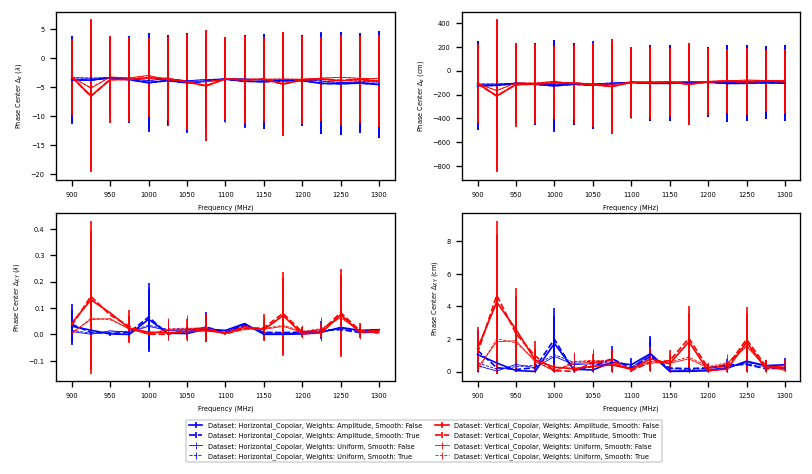

In [ ]:
PC.plot_phase_center();

## Measures and Predicted Phases for selected frequencies

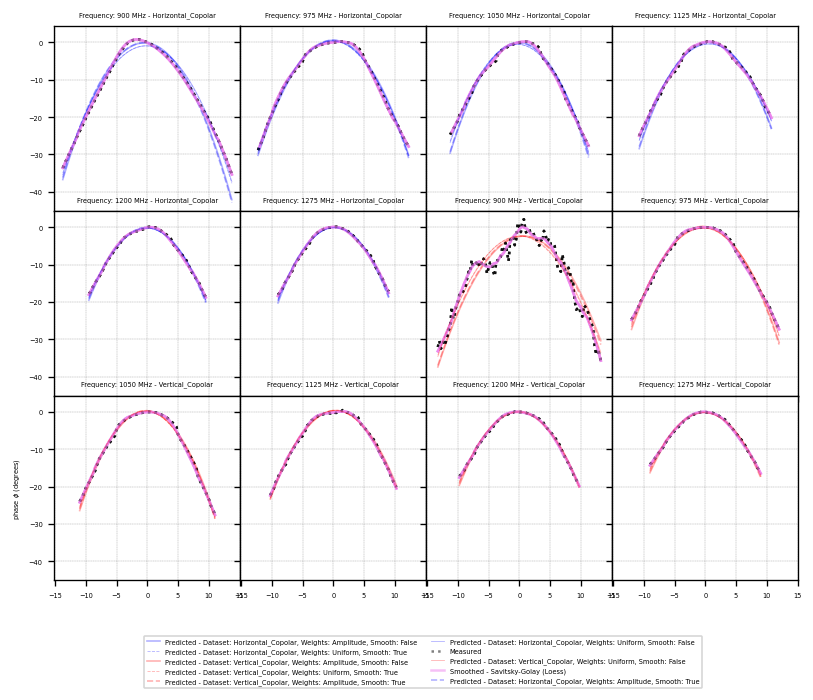

In [ ]:
PC.plot_phases(freqs=freqs);

## Statistical Diagnostics

### Scores and Metrics

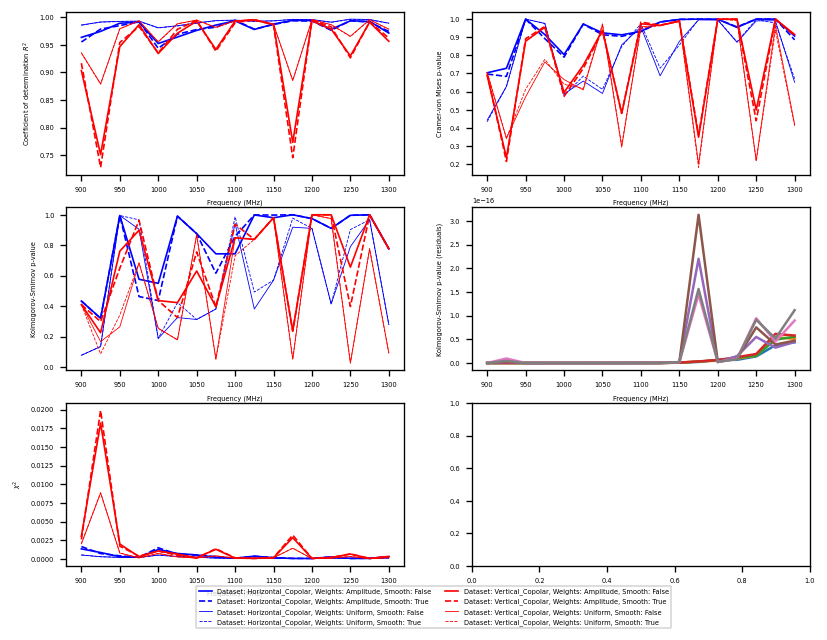

In [ ]:
PC.plot_statistics();

### Quantile Plots for measures and predicted phases after bootstrap

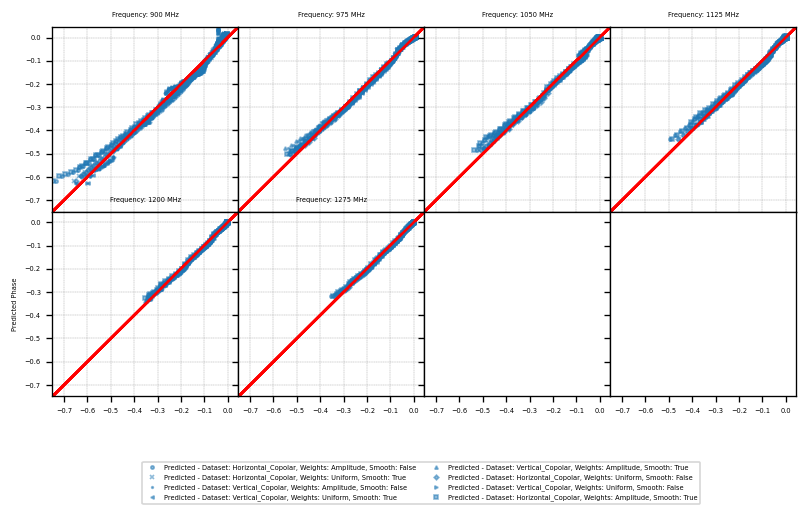

In [ ]:
PC.plot_residuals(freqs=freqs);

### Quantile Plots for residues after bootstrap

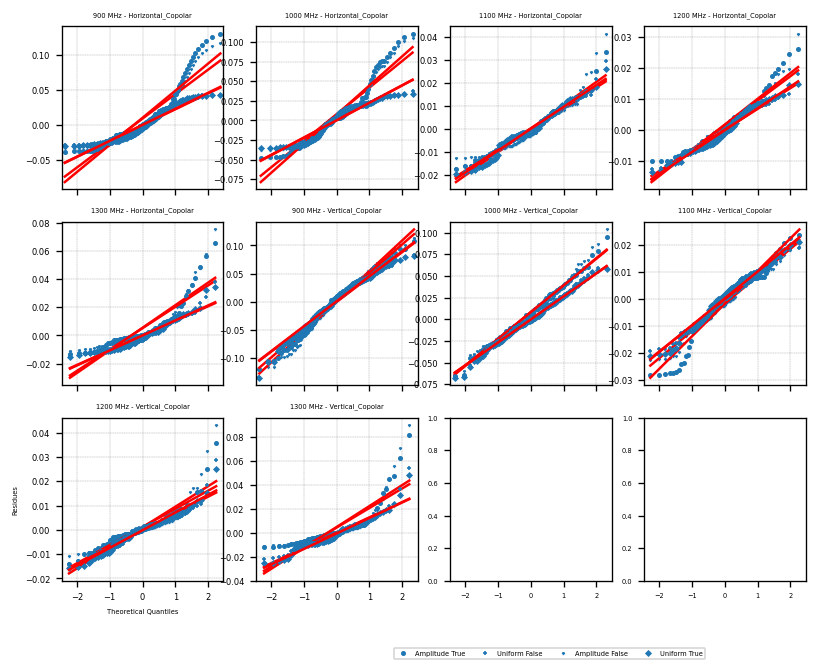

In [ ]:
PC.plot_qq_residuals(freqs=freqs);

## Concluding Remarks

- Cramer Von Mises test shows the googdness of fit, validating the procedure.
- Coefficient of determination indicates a large fraction of measured variance explained by the model.
- Kolmogorov-Smirnof test for residuals indicate that the residuals are not normal distributed.
- Chi squared is too low, combined with the other metrics we should consider large sistematics.
- We did not consider uncertainties for the measured data.
- Smoothing the data did not improve the fit substantially.
- Amplitude weighting had a significat positive impact for the goodness of fit.
- For any future measurements we may observe the following:
  - Measurements for very large angle are waste of time.
  - Rotation in azimuth should be done with the least possible angular resolution.
  - Information regading angle measurement uncertanties is important to obtain a sensible result.
  - Phase uncertanties may be obtained by taking several measurements of phase for each angle. This is easy to implement with VNAs and do not take considerable time. This procedure offer a quantification of phase variance and allows to consider different statistical tests, notably, Lack of Fit Test, and allows us to separate statistical noise from sistematics.
  - Measurement in fresnel region will have strong sistematics and it is not clear if any conclusive result would be drawn from the data.

## Code Availability

https://github.com/barosil/phase_center